Import libraries

In [80]:
#general libraries
import re
import os
import time

#data manipulation libraries
import pandas as pd
import numpy as np

#data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#transformers libraries
from transformers import AutoTokenizer

#metrics libraries
from rouge_score import rouge_scorer
from bert_score import BERTScorer

#pdf libraries
from fpdf import FPDF

#paralelization libraries
from joblib import Parallel, delayed

#for logging purposes
import logging

Load the data

In [81]:
def load_data(dataset_path):
    dataset = pd.read_csv(dataset_path)
    
    # Drop rows with NaN values in critical columns
    dataset = dataset.dropna()

    if dataset.shape[0] > 10000:
        dataset = dataset.sample(10000)
    return dataset

Check the dataset

EDA to identify issues and data cleaning

Remove duplicated rows

In [82]:
def remove_duplicates(dataset):
    dataset_unique = dataset[~dataset.duplicated(keep='first')]
    dataset_unique.describe()
    return dataset_unique

Check if dataset is good qualitty for training a summarization model

Calculate the similarity to ensure the summaries represent the judgements

In [83]:
def compute_similarity(dataset, judgement_col, summary_col, subset_size=20, output_file="cosine_similarity_heatmap.png"):

    dataset = dataset.copy()
    
    # Remove any remaining NaN values
    dataset = dataset.dropna(subset=[judgement_col, summary_col])

    # Initialize vectorizer
    vectorizer = TfidfVectorizer()

    # Combine judgements and summaries for consistent vectorization
    combined_texts = pd.concat([dataset[judgement_col], dataset[summary_col]])
    tfidf_matrix = vectorizer.fit_transform(combined_texts)

    # Split back into judgements and summaries
    n_judgements = len(dataset[judgement_col])
    judgements_tfidf = tfidf_matrix[:n_judgements]
    summaries_tfidf = tfidf_matrix[n_judgements:]

    # Compute cosine similarity
    similarity_scores = cosine_similarity(judgements_tfidf, summaries_tfidf)
    diagonal_similarity_scores = np.diagonal(similarity_scores)
    dataset.loc[:, "Similarity Score"] = diagonal_similarity_scores

    subset_judgements = judgements_tfidf[:subset_size]
    subset_summaries = summaries_tfidf[:subset_size]
    subset_similarity_matrix = cosine_similarity(subset_judgements, subset_summaries)

    plt.figure(figsize=(10, 6))
    sns.heatmap(subset_similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Cosine Similarity Heatmap (Judgements vs. Summaries)")
    plt.xlabel("Summaries")
    plt.ylabel("Judgements")
    plt.savefig(output_file)
    plt.show()

In [84]:
def rouge_score(response, summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(response, summary)
    f1_scores = [score.fmeasure for score in scores.values()]
    return f1_scores[0], f1_scores[1], f1_scores[2]

In [85]:
def bert_score(response, summary):
    scorer = BERTScorer(model_type='bert-base-uncased')
    P, R, F1 = scorer.score([response], [summary])
    return F1.item()

In [86]:
def compute_metrics(dataset, judgement_col, summary_col):

    dataset = dataset.copy()

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bert_scores = []

    for index, row in dataset.iterrows():
        judgement = row[judgement_col]
        summary = row[summary_col]
        
        rouge1, rouge2, rougeL = rouge_score(judgement, summary)
        bert = bert_score(judgement, summary)
        
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)
        bert_scores.append(bert)

    dataset.loc[:, "ROUGE-1"] = rouge1_scores
    dataset.loc[:, "ROUGE-2"] = rouge2_scores
    dataset.loc[:, "ROUGE-L"] = rougeL_scores
    dataset.loc[:, "BERT"] = bert_scores

    metrics_list = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERT"]

    for metric in metrics_list:
        plt.figure(figsize=(10, 6))
        plt.hist(dataset[metric], bins=20, alpha=0.7, label=metric, color='skyblue')
        
        mean_value = dataset[metric].mean()
        
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean_value:.2f}")
        
        plt.title(f"Histogram of {metric}")
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.legend()
        
        plt.savefig(f"metrics_histogram_{metric}.png")
        plt.show()
        plt.close()

    means = dataset["ROUGE-1"].mean(), dataset["ROUGE-2"].mean(), dataset["ROUGE-L"].mean(), dataset["BERT"].mean()

    return means

Calculate the lenght of the judgements and summaries and remove the outliers

In [87]:
def count_tokens(texts, tokenizer):
    return [len(tokenizer(text, truncation=True, padding=False)["input_ids"]) for text in texts]

In [88]:
def analyze_and_filter_token_distribution(dataset, judgement_col, summary_col, tokenizer_model="t5-small"):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

    dataset = dataset.copy()


    dataset.loc[:, "Judgement_Tokens"] = count_tokens(dataset[judgement_col], tokenizer)
    dataset.loc[:, "Summary_Tokens"] = count_tokens(dataset[summary_col], tokenizer)

    judgement_quartiles = dataset["Judgement_Tokens"].quantile([0.25, 0.5, 0.75]).to_dict()
    summary_quartiles = dataset["Summary_Tokens"].quantile([0.25, 0.5, 0.75]).to_dict()

    judgement_lower_quartile = dataset["Judgement_Tokens"].quantile(0.10)
    judgement_upper_quartile = dataset["Judgement_Tokens"].quantile(0.90)
    summary_lower_quartile = dataset["Summary_Tokens"].quantile(0.10)
    summary_upper_quartile = dataset["Summary_Tokens"].quantile(0.90)

    dataset_filtered = dataset[
        (dataset["Judgement_Tokens"] >= judgement_lower_quartile) &
        (dataset["Judgement_Tokens"] <= judgement_upper_quartile) &
        (dataset["Summary_Tokens"] >= summary_lower_quartile) &
        (dataset["Summary_Tokens"] <= summary_upper_quartile)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(dataset["Judgement_Tokens"], bins=10, alpha=0.6, label="Judgements")
    plt.hist(dataset["Summary_Tokens"], bins=10, alpha=0.6, label="Summaries")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.title("Token Distribution in Judgements and Summaries")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Judgement Quartiles:", judgement_quartiles)
    print("Summary Quartiles:", summary_quartiles)

    mean_judgement_tokens = dataset["Judgement_Tokens"].mean()
    mean_summary_tokens = dataset["Summary_Tokens"].mean()

    return dataset_filtered, mean_judgement_tokens, mean_summary_tokens

Calculate the reduction of the judgements into summaries

In [89]:
def calculate_reduction(dataset, judgement_tokens_col, summary_tokens_col, output_file="reduction_percentage_histogram.png"):
    dataset = dataset.copy()

    dataset.loc[:, "Reduction (%)"] = ((1 - dataset[summary_tokens_col] / dataset[judgement_tokens_col]) * 100)

    mean_reduction = dataset["Reduction (%)"].mean()

    plt.figure(figsize=(10, 6))
    plt.hist(dataset["Reduction (%)"], bins=50, color="skyblue", alpha=0.7, edgecolor="black")
    plt.axvline(mean_reduction, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_reduction:.2f}%")
    plt.title("Reduction Percentage Distribution")
    plt.xlabel("Reduction (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig(output_file)
    plt.show()

    return mean_reduction

In [90]:
def create_pdf_report(calculated_values, left_column_images, right_column_images, dataset_name):
    class PDF(FPDF):
        def header(self):
            self.set_font('CMU', 'B', 12)
            self.cell(0, 10, f'Dataset Preparation Report: {dataset_name} dataset', align='C', ln=True)
            self.ln(10)

    pdf = PDF()

    pdf.add_font('CMU', '', 'cmunrm.ttf', uni=True)  # Regular font
    pdf.add_font('CMU', 'B', 'cmunobx.ttf', uni=True)  # Bold font
    pdf.add_font('CMU', 'I', 'cmunci.ttf', uni=True)  # Italic font

    pdf.set_auto_page_break(auto=True, margin=5)
    pdf.add_page()

    page_width = pdf.w - 2 * pdf.l_margin
    column_width = page_width / 2
    left_column_x = pdf.l_margin
    right_column_x = pdf.l_margin + column_width

    pdf.set_font('CMU', 'B', 10)
    pdf.set_x(left_column_x) 

    pdf.set_font('CMU', '', 8)
    row_height = 8

    cell_width = 35
    table_width = cell_width * 2

    start_x = left_column_x + (column_width - table_width) / 2

    # Loop through the calculated values and draw the table
    for key, value in calculated_values.items():
        pdf.set_x(start_x)  # Set starting position for each row
        pdf.cell(cell_width, row_height, key, border=1, align='L')  # Key column
        pdf.cell(cell_width, row_height, str(value), border=1, align='R')  # Value column
        pdf.ln(row_height)  # Move to the next row

    pdf.ln(5)

    left_image_y = pdf.get_y()
    images_start = left_image_y
    pdf.image("reduction_percentage_histogram.png", x=left_column_x, y=left_image_y, w=column_width - 5)
    left_image_y += column_width / 2 + 5 

    pdf.image("metrics_histogram_ROUGE-1.png", x=left_column_x, y=left_image_y, w=column_width - 5)
    left_image_y += column_width / 2 + 5 

    pdf.image("metrics_histogram_ROUGE-2.png", x=left_column_x, y=left_image_y, w=column_width - 5)

    pdf.set_y(pdf.l_margin) 
    pdf.set_x(right_column_x)
    right_image_y = pdf.get_y() + 30

    pdf.image("cosine_similarity_heatmap.png", x=right_column_x, y=right_image_y, w=column_width - 5)
    right_image_y += column_width / 2 + 5  


    right_image_y = images_start
    pdf.image("metrics_histogram_ROUGE-L.png", x=right_column_x, y=right_image_y, w=column_width - 5)
    right_image_y += column_width / 2 + 5 

    pdf.image("metrics_histogram_BLEU.png", x=right_column_x, y=right_image_y, w=column_width - 5)
    right_image_y += column_width / 2 + 5 

    pdf.image("metrics_histogram_METEOR.png", x=right_column_x, y=right_image_y, w=column_width - 5)

    pdf.output(f'data_preparation_report_{dataset_name}.pdf', 'F')


In [91]:
def pipeline():
    datasets = ["legal"]
    for dataname in datasets:
        dataset_path = f'datasets/{dataname}.csv'

        dataset = load_data(dataset_path)

        dataset_unique = remove_duplicates(dataset)

        compute_similarity(
            dataset=dataset_unique, 
            judgement_col="judgement", 
            summary_col="summary", 
            subset_size=20, 
            output_file="cosine_similarity_heatmap.png"
        )

        mean_ROUGE1, mean_ROUGE2, mean_ROUGEL, mean_BERT = compute_metrics(
            dataset=dataset_unique, 
            judgement_col="judgement", 
            summary_col="summary"
        )

        dataset_filtered, mean_judgement_lenght, mean_summary_lenght = analyze_and_filter_token_distribution(
            dataset=dataset_unique,
            judgement_col="judgement",
            summary_col="summary",
            tokenizer_model="t5-small"
        )

        mean_reduction = calculate_reduction(
            dataset=dataset_filtered,
            judgement_tokens_col="Judgement_Tokens",
            summary_tokens_col="Summary_Tokens",
            output_file="reduction_percentage_histogram.png"
        )


        updated_dataset = dataset_filtered[['judgement', 'summary']]

        calculated_values = {
            "Dataset Size": round(dataset_filtered.shape[0], 2),
            "Mean Judgement Lenght": f'{round(mean_judgement_lenght, 2)} tokens',
            "Mean Summary Lenght": f'{round(mean_summary_lenght, 2)} tokens',
            "Mean Reduction": f'{round(mean_reduction, 2)} %',
            "Mean ROUGE-1": round(mean_ROUGE1, 2),
            "Mean ROUGE-2": round(mean_ROUGE2, 2),
            "Mean ROUGE-L": round(mean_ROUGEL, 2),
            "Mean BERT": round(mean_BERT, 2)
        }
        
        create_pdf_report(
            calculated_values=calculated_values,
            left_column_images=["metrics_histogram_ROUGE-L.png", "metrics_histogram_ROUGE-1.png", "metrics_histogram_ROUGE-2.png"],
            right_column_images=["cosine_similarity_heatmap.png", "metrics_histogram_BERT.png", "reduction_percentage_histogram.png"],
            dataset_name=dataname
        )

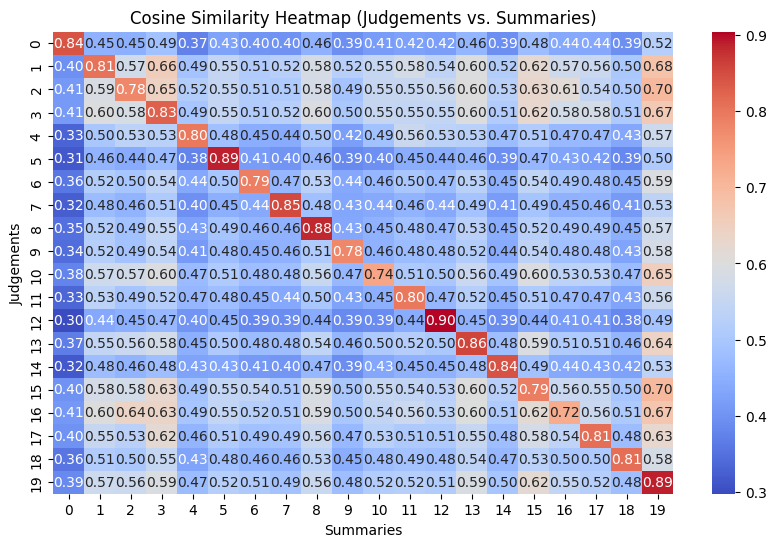

KeyboardInterrupt: 

In [92]:
pipeline()